This notebook evaluates which size dataset is the best for Random Forest Regression performance by plotting F1 score as a function of ratio of 0 and 1 classes.

Init and load data.

In [1]:
%matplotlib inline
import sys,os
util_path = os.path.abspath(os.path.join(os.path.pardir, 'bin'))
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import argparse, logging, json
import datetime as dt
from datetime import timedelta

import itertools
from collections import OrderedDict

import math
import numpy as np
import pandas as pd

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import RandomizedSearchCV, train_test_split, TimeSeriesSplit

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, mean_squared_error, mean_absolute_error, r2_score, classification_report
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, DotProduct, PairwiseKernel

from sklearn.naive_bayes import GaussianNB

from lib.io import IO
from lib.bqhandler import BQHandler
from lib.config import read as cread

pd.set_option('display.width', 1000)

import seaborn as sns
sns.set()
sns.set(style="whitegrid", palette="muted")

os.chdir("/home/jovyan/trains")
os.getcwd()

#warnings.filterwarnings(action='ignore', category=FutureWarning)
#warnings.filterwarnings(action='ignore', category=DeprecationWarning)

'/home/jovyan/trains'

In [2]:
class Options():
    pass
options_weather = Options() 
options_weather.starttime = '2010-01-01'
options_weather.endtime = '2015-01-01'
options_weather.config_filename = 'cnf/classifiers.ini'
options_weather.config_name = 'rfc-weather-codes'
# options.stations_file = 'cnf/stations.json'
options_weather.stations = None #'HKI,KE,KV,HPL,TKL,RI'.split(',')
           
cread(options_weather)

In [3]:
class Options():
    pass
options_rfc_weather = Options() 
options_rfc_weather.starttime = '2010-01-01'
options_rfc_weather.endtime = '2015-01-01'
options_rfc_weather.config_filename = 'cnf/classifiers.ini'
options_rfc_weather.config_name = 'rfc-weather-codes'
# options.stations_file = 'cnf/stations.json'
options_rfc_weather.stations = None #'HKI,KE,KV,HPL,TKL,RI'.split(',')
           
cread(options_rfc_weather)

In [4]:
options_short = Options() 
options_short.starttime = '2010-01-01'
options_short.endtime = '2011-01-01'
options_short.config_filename = 'cnf/classifiers.ini'
options_short.config_name = 'gp-weather-codes'
# options.stations_file = 'cnf/stations.json'
#options_gp.stations = ['PSL','OL','TPE','OV','PM','II','KEM','HKI']
options_short.stations = None #'HKI,KE,KV,HPL,TKL,RI'.split(',')
           
cread(options_short)   

In [5]:
options_all = Options() 
options_all.starttime = '2010-01-01'
options_all.endtime = '2015-01-01'
options_all.config_filename = 'cnf/classifiers.ini'
options_all.config_name = 'bayes-all-codes'
# options.stations_file = 'cnf/stations.json'
options_all.stations = None #'HKI,KE,KV,HPL,TKL,RI'.split(',')
           
cread(options_all)

In [6]:
options_rfc_all  = Options() 
options_rfc_all.starttime = '2010-01-01'
options_rfc_all.endtime = '2011-01-01'
options_rfc_all.config_filename = 'cnf/classifiers.ini'
options_rfc_all.config_name = 'rfc-all-codes'
# options.stations_file = 'cnf/stations.json'
options_rfc_all.stations = None #'HKI,KE,KV,HPL,TKL,RI'.split(',')
           
cread(options_rfc_all)

In [11]:
bq = BQHandler()
io = IO(gs_bucket=options_rfc_all.gs_bucket)

In [12]:
def get_data(options, limit=10): 
    starttime, endtime = io.get_dates(options)
    print('Loading data for {} - {} ...'.format(starttime, endtime))
    
    # Get params
    all_param_names = options.label_params + options.classifier_feature_params + options.meta_params
    aggs = io.get_aggs_from_param_names(options.classifier_feature_params)
    
    data = bq.get_rows(starttime,
                       endtime,
                       loc_col='trainstation',
                       project=options.project,
                       dataset='trains_data',
                       table='features_wo_testset_v4',
                       parameters=all_param_names,
                       locations=options.stations,
                       reason_code_table='reason_codes',
                       reason_codes_exclude=options.reason_codes_exclude,
                       reason_codes_include=options.reason_codes_include
                      )
    print('Filtering data...')
    data = io.filter_train_type(labels_df=data,
                                train_types=['K','L'],
                                sum_types=True,
                                train_type_column='train_type',
                                location_column='trainstation',
                                time_column='time',
                                sum_columns=['delay'],
                                aggs=aggs)

    data.sort_values(by=['time', 'trainstation'], inplace=True)
    #data.set_index('time', inplace=True)

    data = io.calc_delay_avg(data)
    data['class'] = data['delay'].map(lambda x: 1 if x > options.delay_limit else 0)
    data = data.assign(month=lambda df: df.loc[:, 'time'].map(lambda x: x.month))
    #options.classifier_feature_params.append('month')
    
    print('Train data contain {} rows...'.format(len(data)))
    #data_train, data_val = train_test_split(data, test_size=0.3)

    # Get test data
    s = dt.datetime.strptime('2011-02-01', "%Y-%m-%d")
    e = dt.datetime.strptime('2011-03-01', "%Y-%m-%d")
    test_data = bq.get_rows(s,
                            e,
                            loc_col='trainstation',
                            project=options.project,
                            dataset=options.feature_dataset,
                            table=options.test_table,
                            locations=options.locations,
                            parameters=all_param_names,
                            reason_code_table=options.reason_code_table,
                            reason_codes_exclude=options.reason_codes_exclude,
                            reason_codes_include=options.reason_codes_include
                            )

    test_data = io.filter_train_type(labels_df=test_data,
                                     train_types=['K','L'],
                                     sum_types=True,
                                     train_type_column='train_type',
                                     location_column='trainstation',
                                     time_column='time',
                                     sum_columns=['delay'],
                                     aggs=aggs)

    test_data.set_index('time', inplace=True)
    
    test_data = io.calc_delay_avg(test_data)
    test_data['class'] = test_data['delay'].map(lambda x: 1 if x > options.delay_limit else 0)
    test_data = test_data.assign(month=lambda df: df.index.map(lambda x: x.month))
    test_data['month'] = test_data.index.map(lambda x: x.month)
    
    return data, test_data

In [13]:
feature_params = options_weather.classifier_feature_params + ['month']

In [14]:
%%time
data_train_weather, data_test_weather = get_data(options_weather)

Loading data for 2010-01-01 00:00:00 - 2015-01-01 00:00:00 ...


/opt/conda/lib/python3.8/site-packages/google/cloud/bigquery/client.py:410: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  warnings.warn(


Filtering data...
Train data contain 6879 rows...
CPU times: user 710 ms, sys: 81.1 ms, total: 791 ms
Wall time: 3.88 s


In [15]:
%%time
data_train_rfc_weather, data_test_rfc_weather = get_data(options_rfc_weather)

Loading data for 2010-01-01 00:00:00 - 2015-01-01 00:00:00 ...
Filtering data...
Train data contain 6879 rows...
CPU times: user 600 ms, sys: 68.3 ms, total: 668 ms
Wall time: 4 s


In [16]:
%%time
data_train_rfc_all, data_test_rfc_all = get_data(options_rfc_all)

Loading data for 2010-01-01 00:00:00 - 2011-01-01 00:00:00 ...
Filtering data...
Train data contain 2319364 rows...
CPU times: user 4min 1s, sys: 33.6 s, total: 4min 35s
Wall time: 10min 45s


In [17]:
%%time
data_train_all, data_test_all = get_data(options_all)

Loading data for 2010-01-01 00:00:00 - 2015-01-01 00:00:00 ...
Filtering data...
Train data contain 10311720 rows...
CPU times: user 11min 32s, sys: 1min 12s, total: 12min 44s
Wall time: 26min 47s


In [18]:
%%time
data_train_short, data_test_short = get_data(options_short)

Loading data for 2010-01-01 00:00:00 - 2011-01-01 00:00:00 ...
Filtering data...
Train data contain 3629 rows...
CPU times: user 363 ms, sys: 21.8 ms, total: 385 ms
Wall time: 7.06 s


In [19]:
data_test_all.head(2)

delay  min_temperature  mean_dewpoint  mean_winddirection  mean_windspeedms  max_snowdepth  max_n  max_precipitation3h  max_precipitation6h trainstation train_type  train_count  count  class  month
time                                                                                                                                                                                                                            
2011-02-26 11:00:00+00:00   46.0             -7.5           -6.0               197.6               7.2           38.0    8.0                  0.0                  0.0          KJÄ          K            1    NaN      1      2
2011-02-02 11:00:00+00:00   34.0             -9.2           -8.1                96.5               3.4           38.0    8.0                  1.2                  3.0          KJÄ          K            1    NaN      1      2

In [20]:
def balance_and_train(data_train, data_test, balance_ratio, 
                      counts, counts2, f1s, recalls, precisions, 
                      classifier, feature_params, normalise=True, cv=None, n_iter=10):

    print('{}..'.format(balance_ratio),end='')

    y_test = data_test.loc[:,'class'].astype(np.int32).values
    X_test_classifier = data_test.loc[:,feature_params].copy().astype(np.float32).values
    
    if balance_ratio > 0:
        # Balance
        try:
            count = data_train.groupby('class').size().min()
            count_class_0 = int(min((balance_ratio*count), data_train.loc[(data_train['class'] == 0)].shape[0]))
            
            if count_class_0/balance_ratio < count:
                count = int(count_class_0/balance_ratio)

            data_train = pd.concat([data_train.loc[data_train['class'] == 0].sample(n=count_class_0),
            data_train.loc[data_train['class'] == 1].sample(n=count)])

        except:
            print('No samples in some class:\n{}',format(data_train.groupby('class').size().min()))
            return
        

        # Pick training data
        y_train = data_train.loc[:,'class'].astype(np.int32).values
        X_train_classifier = data_train.loc[:,feature_params].copy().astype(np.float32).values
    else:
        #count = data_train.groupby('class').size().max()
        ratio = 1/(-1*balance_ratio)
        smote = SMOTE(sampling_strategy=ratio)
        
        y_train = data_train.loc[:,'class'].astype(np.int32).values
        X_train_classifier = data_train.loc[:,feature_params].copy().astype(np.float32).values

        X_train_classifier, y_train = smote.fit_resample(X_train_classifier, y_train)
        count = len(y_train[(y_train == 1)])
        count_class_0 = len(y_train)-count

    #print('Training data size: {}'.format(len(X_train_classifier)))
    
    # Pick features and labels and normalise
    if normalise:
        #print('Normalising...')
        xscaler_classifier = StandardScaler()
        X_train_classifier = xscaler_classifier.fit_transform(X_train_classifier)
        X_test_classifier = xscaler_classifier.transform(X_test_classifier)
    
    # Train
    if cv is not None:
        if cv == 'RFC':
            param_grid = {"n_estimators": [5, 10, 25, 50],
                  "max_depth": [3, 10, 20, None],
                  "max_features": ["auto", "sqrt", "log2", None],
                  "min_samples_split": [2,5,10],
                  "min_samples_leaf": [1, 2, 4, 10],
                  "bootstrap": [True, False]}
        elif cv == 'GBDT':
            param_grid = {
                "loss": ['deviance', 'exponential'],
                'learning_rate': [.001, .01, .1],
                "n_estimators": [50, 100, 200],
                'subsample': [.1, .25, .5, 1],
                "min_samples_split": [2,5,10],
                #'min_weight_fraction_leaf': [0, .1, 0,25, .45],
                "max_depth": [3, 10, 20, None],
                "max_features": ["auto", "sqrt", "log2", None],
                'ccp_alpha': [0, .001, 0.1]
            }

        random_search = RandomizedSearchCV(classifier,
                                           param_distributions=param_grid,
                                           scoring='f1_weighted',
                                           #scoring='recall',
                                           n_iter=n_iter,
                                           n_jobs=-1,
                                           cv=TimeSeriesSplit(n_splits=5),
                                           refit=True)

        random_search.fit(X_train_classifier, y_train)
        
        classifier = random_search.best_estimator_
    else:        
        classifier.fit(X_train_classifier, y_train)
        
    # Show and return test performance
    y_pred = classifier.predict(X_test_classifier)
    
    #f1 = f1_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')
    f1 = 2*recall*precision/(recall+precision)
    
    counts.append(count_class_0)
    counts2.append(count)
    f1s.append(f1) 
    recalls.append(recall)
    precisions.append(precision)

In [21]:
def plot_results(r, counts, counts2, f1s, recalls, precisions, model='', fs=20, dpi=70):
    fig, ax1 = plt.subplots(figsize=(15,4), dpi=dpi)
    ax2 = ax1.twinx()

    plt.title('{} performance as a function of balance ratio'.format(model), fontsize=fs)
    plt.xlabel("Balance ratio", fontsize=fs)
    ax1.set_ylabel("Number of samples", fontsize=fs)
    ax2.set_ylabel('F1 score', fontsize=fs)

    lns1 = ax1.bar([x-.2 for x in r], counts, width=.3, label='Number of samples in class 0', color='xkcd:tea')
    lns2 = ax1.bar([x+.2 for x in r], counts2, width=.3, label='Number of samples in class 1', color='xkcd:indigo')

    lns3 = ax2.plot(r, f1s, label='F1 score', color='black')
    lns4 = ax2.plot(r, recalls, label='Recall', color='black', linestyle='dashed')
    lns5 = ax2.plot(r, precisions, label='Precision', color='black', linestyle='dotted')

    p = ['{}/1'.format((-1*i)) if i < 0 else '1/{}'.format(i) for i in r]

    plt.xticks(ticks=r, labels=p)

    lns = [lns1]+[lns2]+lns3+lns4+lns5
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, prop={'size': fs}, loc='upper center', bbox_to_anchor=(0.5, 1.6), ncol=2)

    ax1.tick_params(axis='both', which='major', labelsize=3/4*fs)
    ax1.tick_params(axis='both', which='minor', labelsize=3/4*fs)
    ax2.tick_params(axis='both', which='major', labelsize=3/4*fs)
    ax2.tick_params(axis='both', which='minor', labelsize=3/4*fs)

    plt.grid()

In [101]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
        
def plot_many_results(results, model='', fs=20, dpi=70):
    
    fig, ax1 = plt.subplots(figsize=(15,4), dpi=dpi)
    ax2 = ax1.twinx()
    ax3 = ax1.twinx()

    ax3.spines["left"].set_position(("axes", -0.1))
    make_patch_spines_invisible(ax3)
    ax3.spines["left"].set_visible(True)
    ax3.yaxis.set_label_position('left')
    ax3.yaxis.set_ticks_position('left')
       
    plt.title('{} performance as a function of balance ratio'.format(model), fontsize=fs)
    plt.xlabel("Balance ratio", fontsize=fs)

    ax1.set_ylabel("Number of samples", fontsize=fs)
    ax2.set_ylabel('F1 score', fontsize=fs)
    lax = [ax1, ax3]

    markers = ['o', 'x']
    colors = ['xkcd:coral', 'xkcd:dark blue']
    
    i = 0
    lnss = []
    for heading, result in results.items():
        r, counts, counts2, f1s, recalls, precisions = result
        
        ylab = f"No. of samples\n{heading}" if i > 0 else heading
        lax[i].set_ylabel(ylab, fontsize=fs)
        lax[i].tick_params(axis='both', which='major', labelsize=3/4*fs)
        lax[i].tick_params(axis='both', which='minor', labelsize=3/4*fs)

        lns1 = lax[i].bar([x-.2 for x in r], counts, width=.3, label='Number of samples in class 0', color='xkcd:tea')
        lns2 = lax[i].bar([x+.2 for x in r], counts2, width=.3, label='Number of samples in class 1', color='xkcd:indigo')
        plt.xticks(ticks=r, labels=['{}/1'.format((-1*i)) if i < 0 else '1/{}'.format(i) for i in r])
        lax[i].grid(False)
    
        lnss.append(ax2.plot(r, f1s, label=f'F1-score {heading}', color=colors[i], marker=markers[i]))
        lnss.append(ax2.plot(r, recalls, label=f'Recall {heading}', color=colors[i], linestyle='dashed', marker=markers[i]))
        lnss.append(ax2.plot(r, precisions, label=f'Precision {heading}', color=colors[i], linestyle='dotted', marker=markers[i]))
        ax2.set_zorder(10)
        ax2.tick_params(axis='both', which='major', labelsize=3/4*fs)
        ax2.tick_params(axis='both', which='minor', labelsize=3/4*fs)
        ax2.set_ylabel('Score', fontsize=fs)
        ax2.set_yticks([.4,.5,.6,.7])
        ax2.grid(False)
                
        i += 1
    
    lns = []
    for l in lnss: lns += l
    lns = lns + [lns1]+[lns2]
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, prop={'size': fs}, loc='upper center', bbox_to_anchor=(0.4, -.1), ncol=3)

    #plt.tight_layout()
    plt.grid()    

## GNB

In [24]:
%%time
counts_gnb, counts2_gnb, f1s_gnb, r_gnb, recalls_gnb, precisions_gnb = [],[],[],[],[],[]
for i in np.arange(-1,11,1):
    if i != 0:
        r_gnb.append(i)

gnb = GaussianNB()        

for b in r_gnb:
    balance_and_train(data_train_all, #data_train_gnb.loc[(data_train_gnb['train_count']>5),:], 
                      data_test_all, #data_test_gnb.loc[(data_test_gnb['train_count']>5),:], 
                      b, 
                      counts_gnb, 
                      counts2_gnb, 
                      f1s_gnb, 
                      recalls_gnb, 
                      precisions_gnb, 
                      gnb, 
                      options_all.classifier_feature_params+['month'],
                      True,
                      None)

-1..1..2..3..4..5..6..7..8..9..10..CPU times: user 3min 36s, sys: 1min 1s, total: 4min 37s
Wall time: 4min 37s


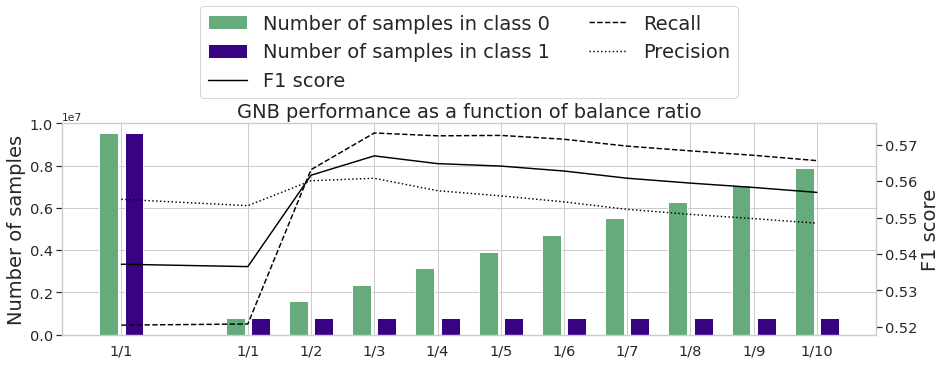

In [25]:
plot_results(r_gnb, counts_gnb, counts2_gnb, f1s_gnb, recalls_gnb, precisions_gnb, 'GNB')

In [26]:
%%time
counts_gnb_weather, counts2_gnb_weather, f1s_gnb_weather, r_gnb_weather, recalls_gnb_weather, precisions_gnb_weather = [],[],[],[],[],[]
for i in np.arange(-1,11,1):
    if i != 0:
        r_gnb_weather.append(i)

gnb_weather = GaussianNB()        

for b in r_gnb_weather:
    balance_and_train(data_train_weather, 
                      data_test_weather, 
                      b, 
                      counts_gnb_weather, 
                      counts2_gnb_weather, 
                      f1s_gnb_weather, 
                      recalls_gnb_weather, 
                      precisions_gnb_weather, 
                      gnb_weather, 
                      options_all.classifier_feature_params+['month'], 
                      True, 
                      None)

-1..1..2..3..4..5..6..7..8..9..10..CPU times: user 150 ms, sys: 4.22 ms, total: 155 ms
Wall time: 151 ms


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


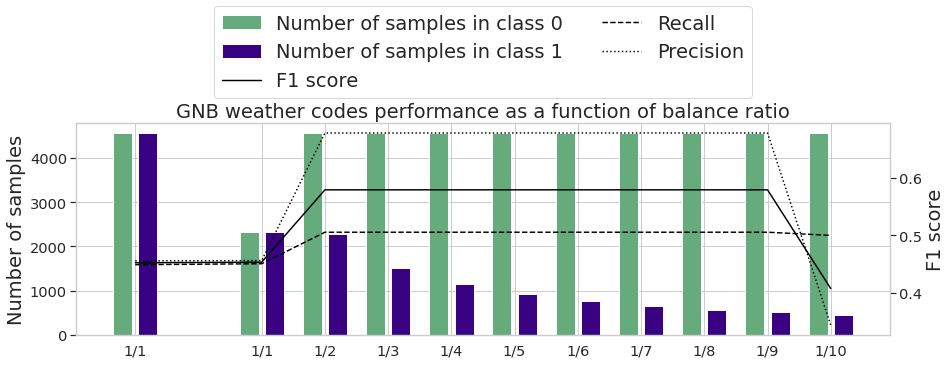

In [27]:
plot_results(r_gnb_weather, counts_gnb_weather, counts2_gnb_weather, 
             f1s_gnb_weather, recalls_gnb_weather, precisions_gnb_weather, 
             'GNB weather codes')

## RFC

Weather codes

In [28]:
data_train_weather.loc[(data_train_weather['time'] > '2011-02-01') & (data_train_weather['time'] < '2011-03-01'), :]

Empty DataFrame
Columns: [delay, lat, lon, pressure, max_temperature, min_temperature, mean_temperature, mean_dewpoint, mean_humidity, mean_winddirection, mean_windspeedms, max_windgust, max_snowdepth, max_n, min_vis, min_clhb, max_precipitation3h, max_precipitation6h, trainstation, time, train_type, train_count, count, class, month]
Index: []

[0 rows x 25 columns]

In [29]:
%%time
counts_rfc_weather, counts2_rfc_weather, f1s_rfc_weather, r_rfc_weather, recalls_rfc_weather, precisions_rfc_weather = [],[],[],[],[],[]
for i in np.arange(-1,11,1):
    if i != 0:
        r_rfc_weather.append(i)

rfc_weather = RandomForestClassifier(n_jobs=-1)

for b in r_rfc_weather:
    balance_and_train(data_train_weather, #data_train_gnb.loc[(data_train_gnb['train_count']>5),:], 
                      data_test_weather, #data_test_gnb.loc[(data_test_gnb['train_count']>5),:], 
                      b, 
                      counts_rfc_weather, 
                      counts2_rfc_weather, 
                      f1s_rfc_weather, 
                      recalls_rfc_weather, 
                      precisions_rfc_weather,
                      rfc_weather,
                      feature_params,
                      False, 
                      'RFC',
                       50)

-1..1..2..3..4..5..6..7..8..

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9..10..CPU times: user 6.86 s, sys: 1.43 s, total: 8.29 s
Wall time: 47.2 s


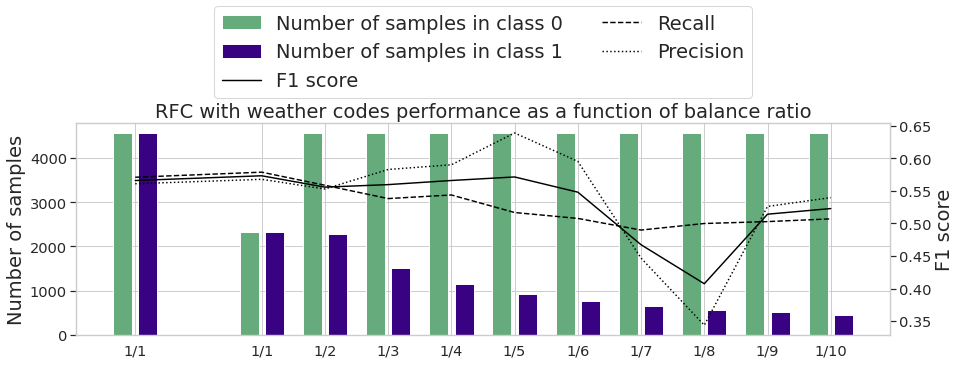

In [30]:
plot_results(r_rfc_weather, 
             counts_rfc_weather, counts2_rfc_weather, 
             f1s_rfc_weather, 
             recalls_rfc_weather, precisions_rfc_weather, 
             'RFC with weather codes')

All codes (short period)

In [31]:
%%time
counts_rfc_all, counts2_rfc_all, f1s_rfc_all, r_rfc_all, recalls_rfc_all, precisions_rfc_all = [],[],[],[],[],[]
for i in np.arange(-1,11,1):
    if i != 0:
        r_rfc_all.append(i)

rfc_all = RandomForestClassifier(n_jobs=-1)

for b in r_rfc_all:
    balance_and_train(data_train_rfc_all, #data_train_gnb.loc[(data_train_gnb['train_count']>5),:], 
                      data_test_rfc_all, #data_test_gnb.loc[(data_test_gnb['train_count']>5),:], 
                      b, 
                      counts_rfc_all, 
                      counts2_rfc_all, 
                      f1s_rfc_all, 
                      recalls_rfc_all, 
                      precisions_rfc_all,
                      rfc_all,
                      options_rfc_all.classifier_feature_params+['month'],
                      False, 
                      'RFC')

-1..

/opt/conda/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


1..

/opt/conda/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


2..

/opt/conda/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


3..

/opt/conda/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


4..

/opt/conda/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


5..

/opt/conda/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


6..

/opt/conda/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


7..

/opt/conda/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


8..

/opt/conda/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9..

/opt/conda/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


10..

/opt/conda/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CPU times: user 1h 44min 45s, sys: 2min 27s, total: 1h 47min 12s
Wall time: 1h 7min 7s


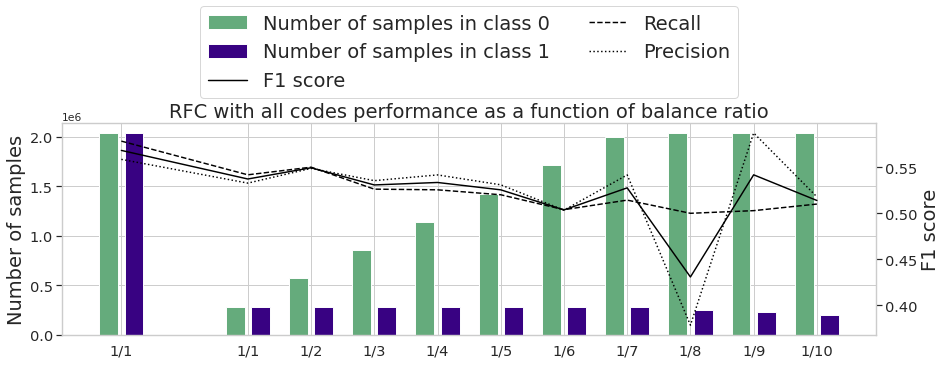

In [32]:
plot_results(r_rfc_all, 
             counts_rfc_all, counts2_rfc_all, 
             f1s_rfc_all, 
             recalls_rfc_all, precisions_rfc_all,
            'RFC with all codes')

## GradientBoostClassifiers

Weather codes

In [33]:
%%time
counts_gbdt_weather, counts2_gbdt_weather, f1s_gbdt_weather, r_gbdt_weather, recalls_gbdt_weather, precisions_gbdt_weather = [],[],[],[],[],[]
for i in np.arange(-1,11,1):
    if i != 0:
        r_gbdt_weather.append(i)

gbdt_weather = GradientBoostingClassifier()

for b in r_gbdt_weather:
    balance_and_train(data_train_rfc_weather,
                      data_test_rfc_weather,
                      b, 
                      counts_gbdt_weather, 
                      counts2_gbdt_weather, 
                      f1s_gbdt_weather, 
                      recalls_gbdt_weather, 
                      precisions_gbdt_weather,
                      gbdt_weather,
                      options_rfc_weather.classifier_feature_params+['month'],
                      False, 
                      'GBDT')

-1..1..2..3..

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4..

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5..

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


6..7..

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8..

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9..

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10..CPU times: user 17.4 s, sys: 250 ms, total: 17.6 s
Wall time: 56.8 s


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


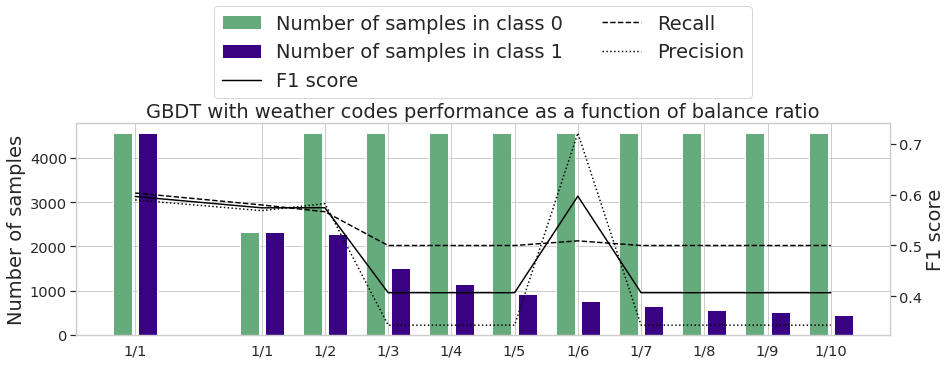

In [34]:
plot_results(r_gbdt_weather, 
             counts_gbdt_weather, counts2_gbdt_weather, 
             f1s_gbdt_weather, 
             recalls_gbdt_weather, precisions_gbdt_weather,
            'GBDT with weather codes')

All codes

In [35]:
%%time
counts_gbdt_all, counts2_gbdt_all, f1s_gbdt_all, r_gbdt_all, recalls_gbdt_all, precisions_gbdt_all = [],[],[],[],[],[]
for i in np.arange(-1,11,1):
    if i != 0:
        r_gbdt_all.append(i)

gbdt_all = GradientBoostingClassifier()

for b in r_gbdt_all:
    balance_and_train(data_train_rfc_all, #data_train_gnb.loc[(data_train_gnb['train_count']>5),:], 
                      data_test_rfc_all, #data_test_gnb.loc[(data_test_gnb['train_count']>5),:], 
                      b, 
                      counts_gbdt_all, 
                      counts2_gbdt_all, 
                      f1s_gbdt_all, 
                      recalls_gbdt_all, 
                      precisions_gbdt_all,
                      gbdt_all,
                      options_rfc_all.classifier_feature_params+['month'],
                      False, 
                      'GBDT')

-1..1..2..

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3..

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4..5..6..

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7..

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8..9..

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10..CPU times: user 1d 9h 58min 4s, sys: 7min 32s, total: 1d 10h 5min 37s
Wall time: 2d 24min 32s


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


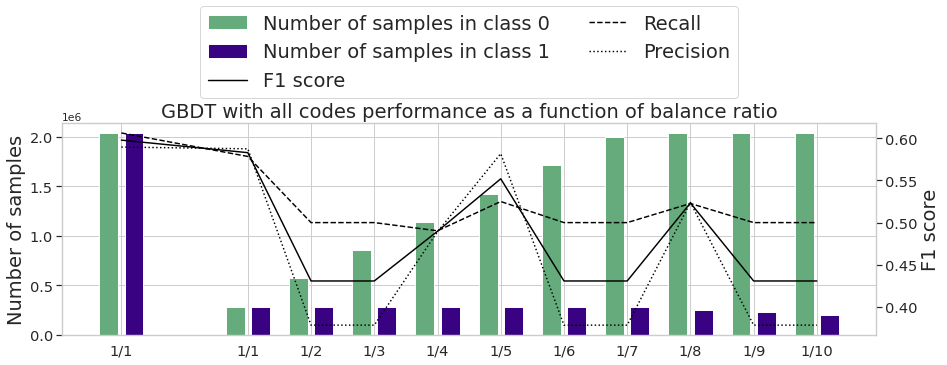

In [36]:
plot_results(r_gbdt_all, 
             counts_gbdt_all, counts2_gbdt_all, 
             f1s_gbdt_all, 
             recalls_gbdt_all, precisions_gbdt_all,
            'GBDT with all codes')

For the case that kernel is lost:

In [108]:
results = {
    'GNB with all codes': (r_gnb, counts_gnb, counts2_gnb, f1s_gnb, recalls_gnb, precisions_gnb),
    'GNB with weather codes': (r_gnb_weather, counts_gnb_weather, counts2_gnb_weather, 
             f1s_gnb_weather, recalls_gnb_weather, precisions_gnb_weather),
    'RFC with all codes': (r_rfc_all, 
             counts_rfc_all, counts2_rfc_all, 
             f1s_rfc_all, 
             recalls_rfc_all, precisions_rfc_all),
    'RFC with weather codes': (r_rfc_weather, 
             counts_rfc_weather, counts2_rfc_weather, 
             f1s_rfc_weather, 
             recalls_rfc_weather, precisions_rfc_weather),
    'GBTC with all codes': (r_gbdt_weather, 
             counts_gbdt_weather, counts2_gbdt_weather, 
             f1s_gbdt_weather, 
             recalls_gbdt_weather, precisions_gbdt_weather),
    'GBTC with weather codes': (r_gbdt_all, 
             counts_gbdt_all, counts2_gbdt_all, 
             f1s_gbdt_all, 
             recalls_gbdt_all, precisions_gbdt_all)
}

In [415]:
results = {
    'GNB with all codes': (r_gnb[4:15], counts_gnb[4:15], counts2_gnb[4:15], f1s_gnb[4:15], recalls_gnb[4:15], precisions_gnb[4:15]),
    'GNB with weather codes': (r_gnb_weather[0:11], counts_gnb_weather[0:11], counts2_gnb_weather[0:11], 
             f1s_gnb_weather[0:11], recalls_gnb_weather[0:11], precisions_gnb_weather[0:11]),
    'RFC with all codes': (r_rfc_all[4:15], 
             counts_rfc_all[4:15], counts2_rfc_all[4:15], 
             f1s_rfc_all[4:15], 
             recalls_rfc_all[4:15], precisions_rfc_all[4:15]),
    'RFC with weather codes': (r_rfc_weather, 
             counts_rfc_weather, counts2_rfc_weather, 
             f1s_rfc_weather, 
             recalls_rfc_weather, precisions_rfc_weather),
    'GBTC with weather codes': (r_gbdt_weather[0:11], 
             counts_gbdt_weather[0:11], counts2_gbdt_weather[0:11], 
             f1s_gbdt_weather[0:11], 
             recalls_gbdt_weather[0:11], precisions_gbdt_weather[0:11]),
    'GBTC with all codes': (r_gbdt_all, 
             counts_gbdt_all, counts2_gbdt_all, 
             f1s_gbdt_all, 
             recalls_gbdt_all, precisions_gbdt_all)
}

In [112]:
results_gnb = {
    'whole': (r_gnb, counts_gnb, counts2_gnb, f1s_gnb, recalls_gnb, precisions_gnb),
    'weather-related': (r_gnb_weather, counts_gnb_weather, counts2_gnb_weather, 
             f1s_gnb_weather, recalls_gnb_weather, precisions_gnb_weather)
}
results_rfc = {
    'whole': (r_rfc_all, 
             counts_rfc_all, counts2_rfc_all, 
             f1s_rfc_all, 
             recalls_rfc_all, precisions_rfc_all),
    'weather-related': (r_rfc_weather, 
             counts_rfc_weather, counts2_rfc_weather, 
             f1s_rfc_weather, 
             recalls_rfc_weather, precisions_rfc_weather)
}
results_gbdt = {
    'whole': (r_gbdt_all, 
             counts_gbdt_all, counts2_gbdt_all, 
             f1s_gbdt_all, 
             recalls_gbdt_all, precisions_gbdt_all),
    'weather-related': (r_gbdt_weather, 
             counts_gbdt_weather, counts2_gbdt_weather, 
             f1s_gbdt_weather, 
             recalls_gbdt_weather, precisions_gbdt_weather)
}

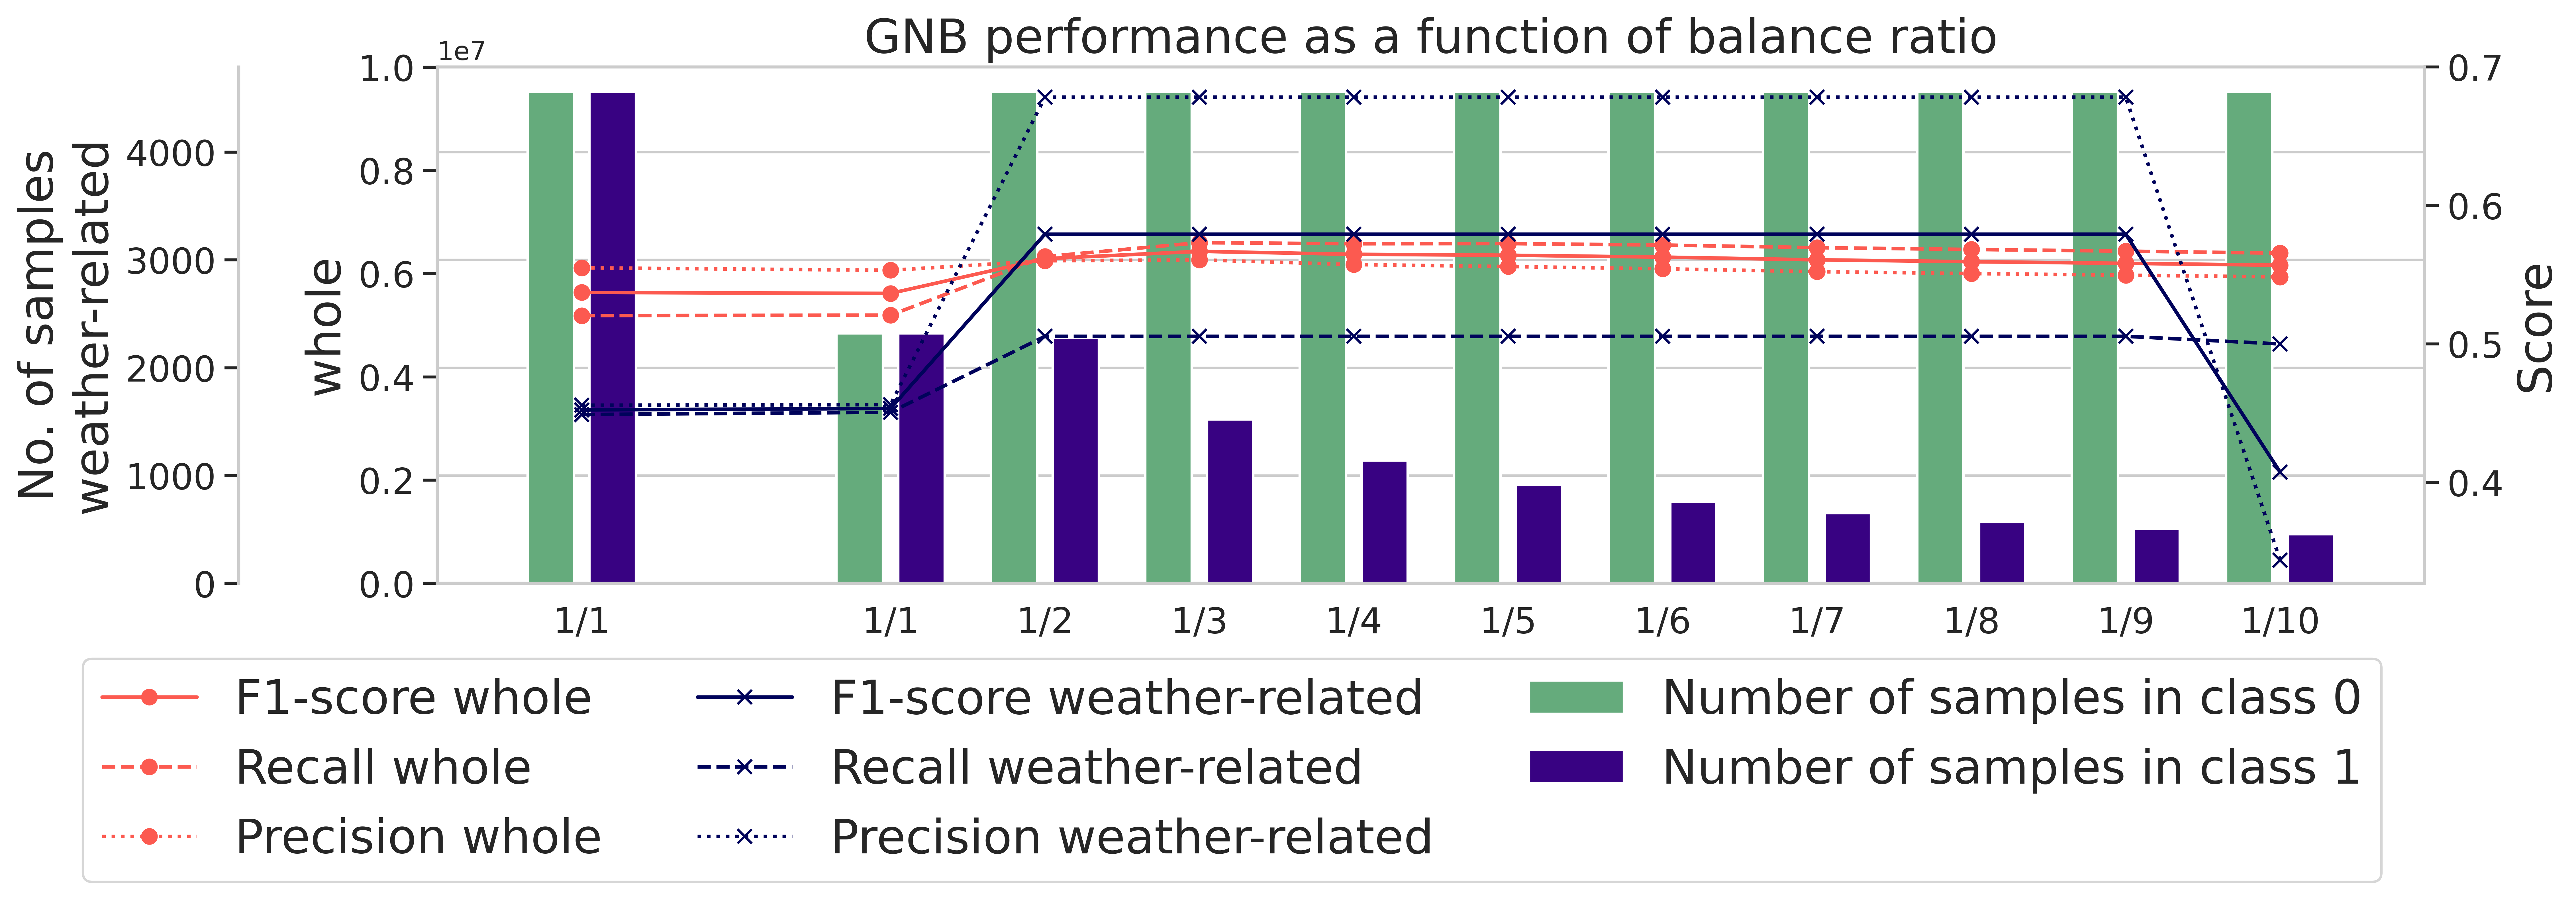

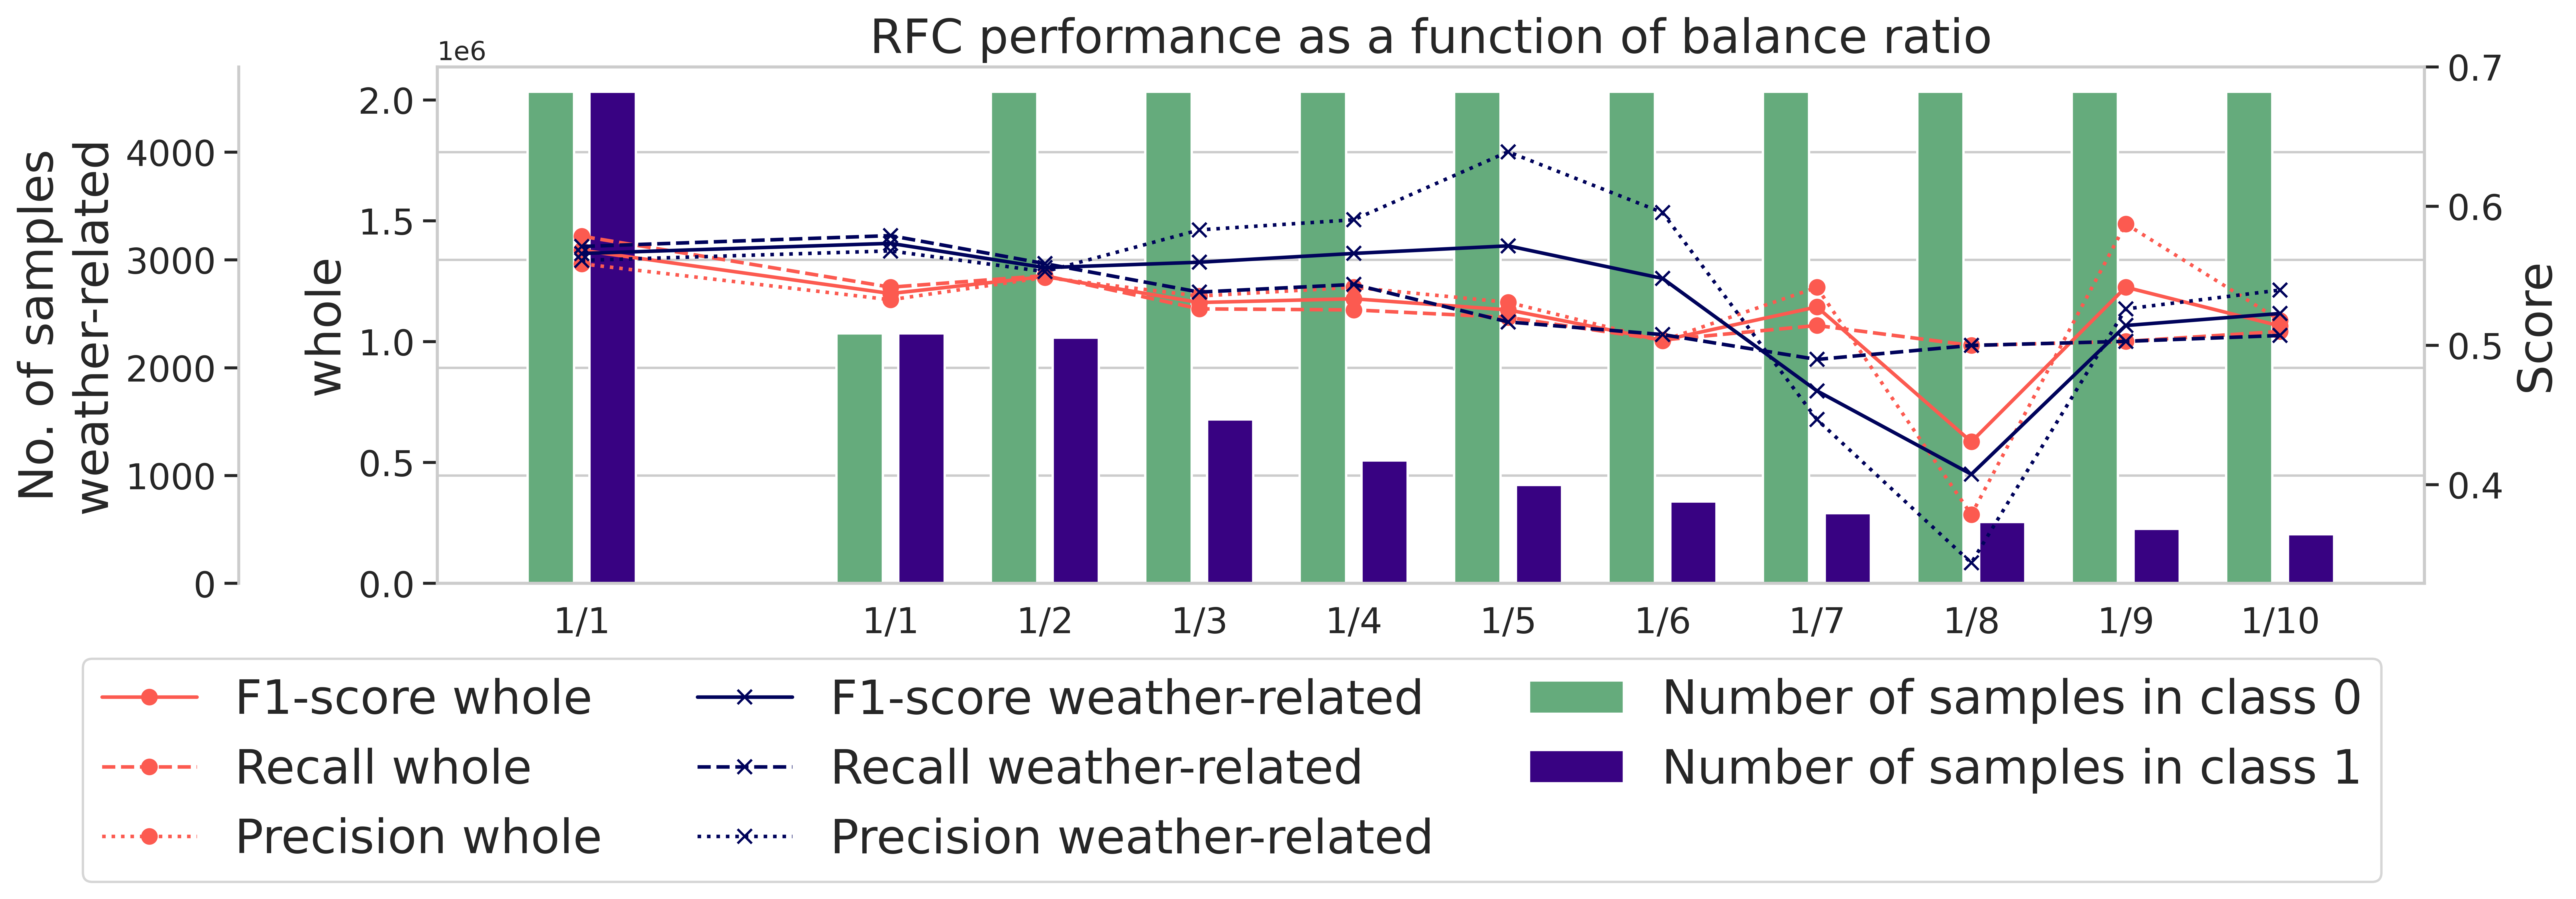

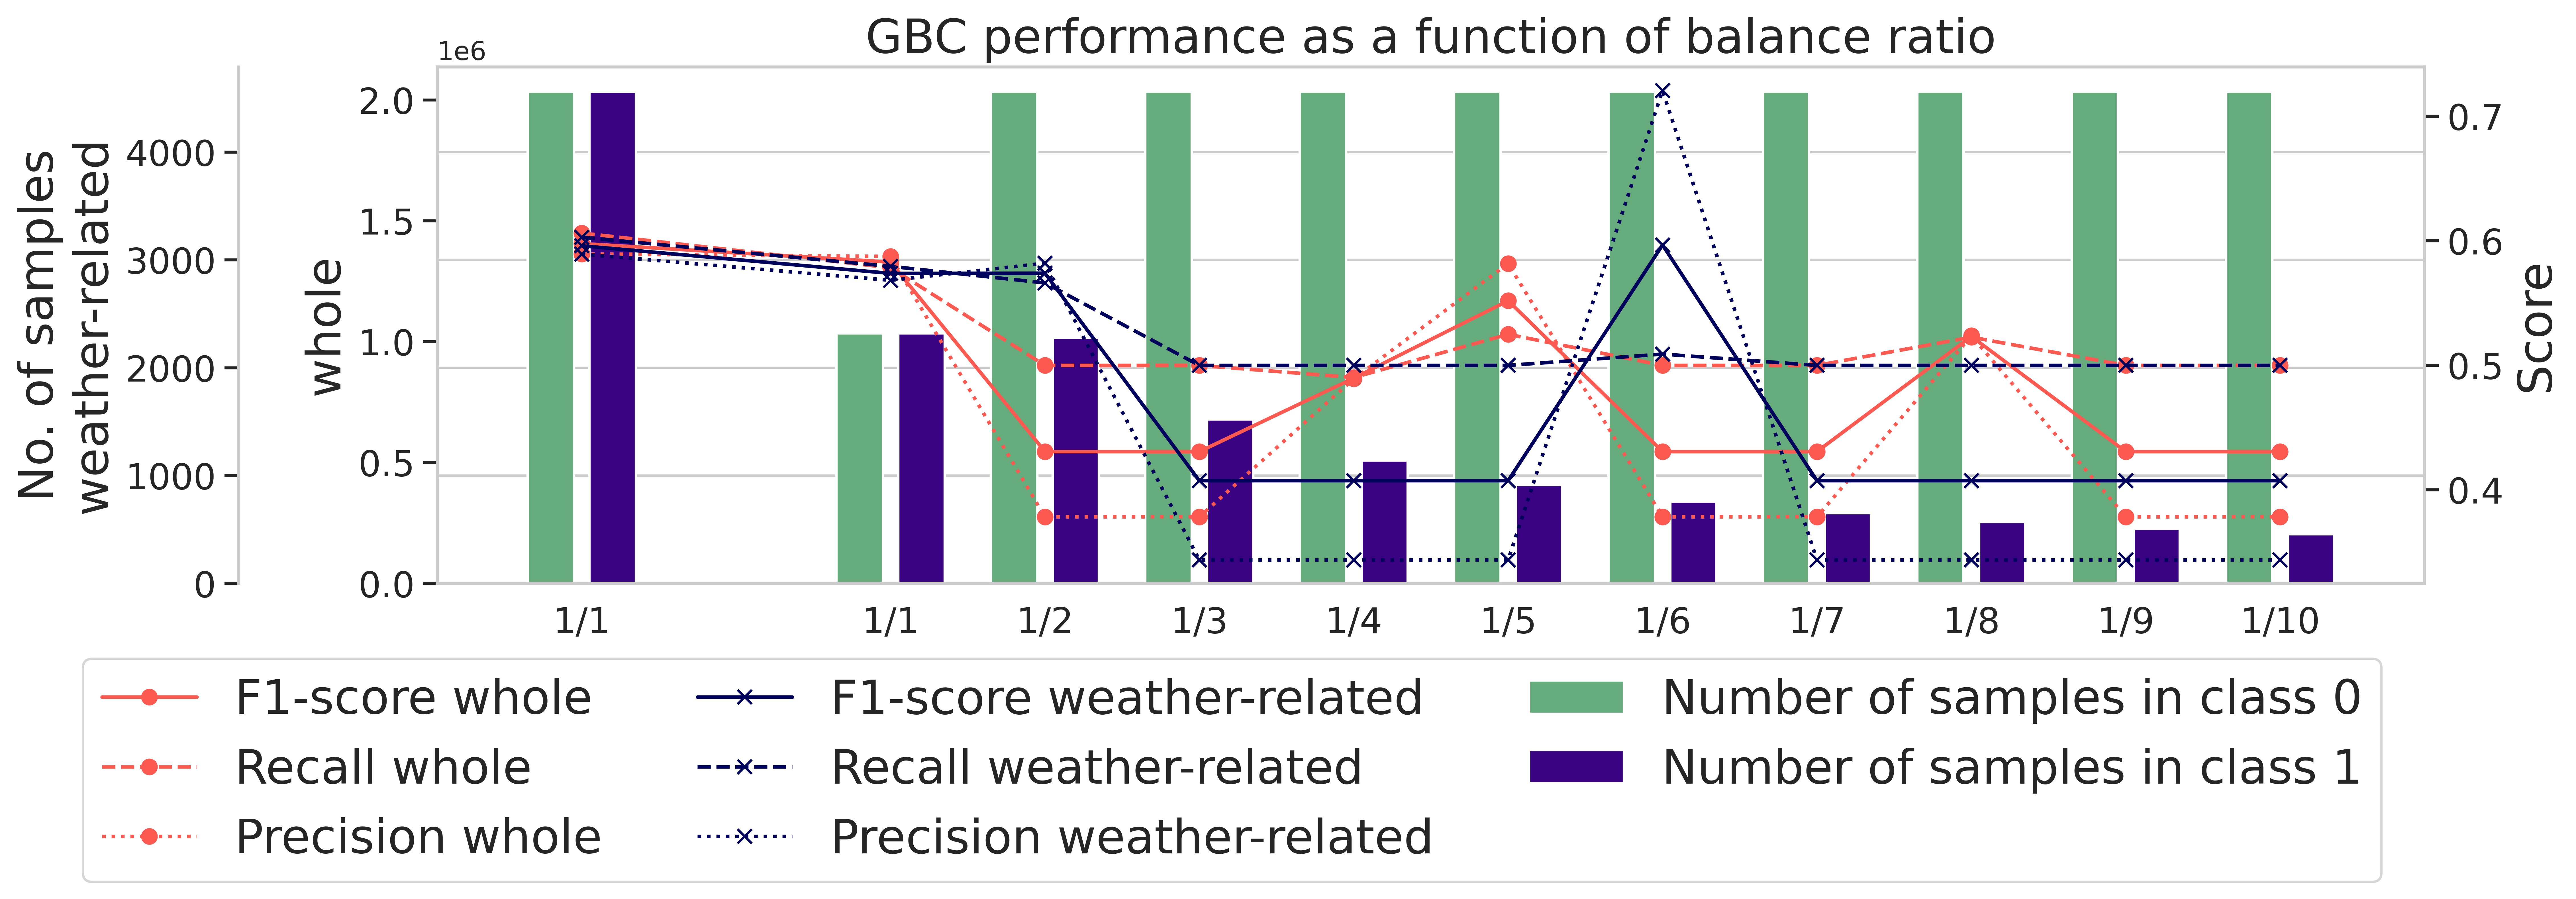

In [113]:
plot_many_results(results_gnb, 'GNB', dpi=600)
plot_many_results(results_rfc, 'RFC', dpi=600)
plot_many_results(results_gbdt, 'GBC', dpi=600)